In [1]:
%load_ext Cython
# https://kaushikghose.wordpress.com/2014/12/08/get-more-out-of-cython/
# http://nealhughes.net/cython1/
# http://codereview.stackexchange.com/questions/43413/optimize-cython-code-with-np-ndarray-contained
# https://github.com/bendmorris/pybioclim/blob/master/src/coords.pyx

In [2]:
import math
import numpy as np
import pandas as pd
import logging
from datetime import datetime, timezone
from datetime import timedelta
import os
import pytz


GEOLIFE_DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
GMT = pytz.timezone('GMT')
BEIJING_TIMEZONE = pytz.timezone('Asia/Shanghai')


def calc_distance(lat1, lon1, lat2, lon2, unit="km"):
    """
    The function returns the distance between two lat, long coordinates in miles or kilometers

    :param lat1: latitude info, in geo reference WGS84
    :param lon1: longitude info, in geo reference WGS84
    :type arg1: float
    :type arg2: float
    :type arg3: float
    :type arg4: float
    :return: the distance between two coordinates in mile or km
    :rtype: float

    :Example:
    >>> calc_distance(40.920320, -74.293288, 40.730975, -74.001509, "km")
    """
    error_msg = "The unit for distance has to be one of mile and km"
    if unit not in ['mile', 'km']:
        raise ValueError(error_msg)
    theta = lon1 -lon2
    dist_angle = math.sin(math.radians(lat1))*math.sin(math.radians(lat2)) \
            + math.cos(math.radians(lat1))*math.cos(math.radians(lat2)) \
            * math.cos(math.radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = math.acos(dist_angle)
    dist_angle = math.degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    km = mile * 1.609344
    if unit == 'mile':
        return mile
    elif unit == 'km':
        return km
    else:
        raise ValueError(error_msg)


def load_gps_plt_data2array(file_dir):
    """
    Load in the gps data in the log file if file directory is given
    Field 1: Latitude in decimal degrees.
    Field 2: Longitude in decimal degrees.
    Field 3: All set to 0 for this dataset.
    Field 4: Altitude in feet (-777 if not valid).
    Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
    Field 6: Date as a string.
    Field 7: Time as a string.
    >>> x_ = load_gps_plt_data2array(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
    """
    gpsdata = np.genfromtxt(file_dir,
                            delimiter=',',
                            skip_header=6,
                            dtype="f8,f8,f8,f8,f8,S10,S8",
                            #dtype=('<f8','<f8','<f8','<f8','<f8','|S10', '|S8'),
                            #dtype=(float,float,float,float,float,'|S10','|S10'),
                            usecols = range(7), # select your own columns
                            names=['lat', 'lon', 'dummy1', 'alt', 'days_passed', 'date_str', 'time'],
                            autostrip=True)
    return gpsdata


def load_gps_plt_data(file_dir):
    """
    Load in the gps data in the log file if file directory is given
    Field 1: Latitude in decimal degrees.
    Field 2: Longitude in decimal degrees.
    Field 3: All set to 0 for this dataset.
    Field 4: Altitude in feet (-777 if not valid).
    Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
    Field 6: Date as a string.
    Field 7: Time as a string.
    >>> x_ = load_gps_plt_data(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
    """
    # gpsdata = pd.read_csv(file_dir, sep=',', header=None, skiprows=6)  # do not use any row for column names by header=None
    gpsdata = pd.read_csv(file_dir, sep=',', header=None, skiprows=6, names=['lat', 'lon', 'dummy1', 'alt', 'days_passed', 'date_str', 'time'])
    gpsdata['datetime'] = gpsdata.ix[:, 5] + ' ' + gpsdata.ix[:, 6]
    # to convert time to Beijing time
    # gpsdata['datetime'] = pd.DatetimeIndex(pd.to_datetime(gpsdata['datetime'],format='%Y-%m-%d %H:%M:%S'),tz='UTC').tz_convert('Asia/Shanghai')
    gpsdata['datetime'] = pd.DatetimeIndex(pd.to_datetime(gpsdata['datetime'],format='%Y-%m-%d %H:%M:%S'),tz='UTC')
    # sample conversion from unix epoch to datetime
    # np.array([1368431149, 1368431150]).astype('datetime64[s]')
    # convert to UTC epoch time in million seconds, first conversion below converts to nano second
    gpsdata['timestamp'] = gpsdata['datetime'].astype(np.int64)/(10**6)
    # convert to UTC epoch time in seconds, where decimal places are for millisecond
    gpsdata['timestamp'] = gpsdata['timestamp'].astype(np.int64) / 1000.
    # remove the records with missing date time
    gpsdata = gpsdata[(gpsdata['timestamp'] > 0) & (gpsdata['lon'].notnull()) & (gpsdata['lat'].notnull())]
    # gpsdata.index = [i for i in range(gpsdata.shape[0])]  # may slow down calculations
    return gpsdata


In [3]:
gps = load_gps_plt_data(file_dir='./data_GeoLife/001/Trajectory/20081023055305.plt')
gpsdata = gps.ix[:, [0,1,8]]
gpsdata_shift = gpsdata[['lat', 'lon', 'timestamp']].shift(1, axis=0)
gpsdata_shift = gpsdata_shift.rename(columns={'lat':'lat_last','lon':'lon_last', 'timestamp':'timestamp_last'})
gpsdata_shift.ix[0, :3] = list(gpsdata.ix[0, ['lat','lon', 'timestamp']])
gpsdata = pd.concat([gpsdata, gpsdata_shift], axis=1)


def append_speed(gpsdata):
    gpsdata['distance'] = np.nan
    gpsdata['timegap_sec'] = gpsdata['timestamp'] - gpsdata['timestamp_last']
    # x_ = 1187142632
    # scale_ = gpsdata.ix[gpsdata.index[0], 'timestamp'] / x_
    # scale_ = min([1.0, 10.0, 100.0, 1000.0], key=lambda x:abs(math.log(x)-math.log(scale_)))
    # gpsdata['timegap_sec'] = gpsdata['timegap_sec'] / scale_
    for i in gpsdata.index:
        value_ = calc_distance(gpsdata.ix[i, 'lat'],
                                          gpsdata.ix[i, 'lon'],
                                          gpsdata.ix[i, 'lat_last'],
                                          gpsdata.ix[i, 'lon_last'], 'km')
        gpsdata.ix[i,'distance'] = (value_)
        gpsdata.ix[gpsdata.timegap_sec <=0, 'timegap_sec'] = (0.001)
        gpsdata['speed'] = 3600. * gpsdata['distance']/gpsdata['timegap_sec']
    return gpsdata

gpsdata = append_speed(gpsdata)
gpsdata

,lat,lon,timestamp,lat_last,lon_last,timestamp_last,distance,timegap_sec,speed
0,39.984094,116.319236,1.224741e+09,39.984094,116.319236,1.224741e+09,0.000000,0.001,0.000000
2,39.984224,116.319402,1.224741e+09,39.984094,116.319236,1.224741e+09,0.020222,6.000,12.133351
4,39.984217,116.319422,1.224741e+09,39.984224,116.319402,1.224741e+09,0.001870,10.000,0.673171
5,39.984710,116.319865,1.224741e+09,39.984217,116.319422,1.224741e+09,0.066553,2.000,119.795174
6,39.984674,116.319810,1.224741e+09,39.984710,116.319865,1.224741e+09,0.006162,5.000,4.436971
7,39.984623,116.319773,1.224741e+09,39.984674,116.319810,1.224741e+09,0.006488,5.000,4.671370
8,39.984606,116.319732,1.224741e+09,39.984623,116.319773,1.224741e+09,0.003972,5.000,2.860108
9,39.984555,116.319728,1.224741e+09,39.984606,116.319732,1.224741e+09,0.005682,5.000,4.090742
10,39.984579,116.319769,1.224741e+09,39.984555,116.319728,1.224741e+09,0.004396,5.000,3.164840
11,39.984579,116.319769,1.224741e+09,39.984579,116.319769,1.224741e+09,0.000000,3.000,0.000000


In [4]:
from itertools import compress
# Filter the noise using rolling median
def index_filter_by_median(signal, threshold=3):
    df = pd.DataFrame(np.array(signal))
    df['pandas'] = df.rolling(10, min_periods=3).median().fillna(0)
    difference = (df[0] - df['pandas'])/(df['pandas'] + 0.01)
    outlier_idx = (difference > threshold) & (df[0] > df[0].quantile(.99))
    return list(compress(range(len(outlier_idx)), outlier_idx))

print(index_filter_by_median(gpsdata['speed']))
gpsdata3 = gpsdata.drop(gpsdata.iloc[index_filter_by_median(gpsdata['speed'])].index)
gpsdata3

[3, 14, 147, 196, 344, 374, 557, 558, 559]


,lat,lon,timestamp,lat_last,lon_last,timestamp_last,distance,timegap_sec,speed
0,39.984094,116.319236,1.224741e+09,39.984094,116.319236,1.224741e+09,0.000000,0.001,0.000000
2,39.984224,116.319402,1.224741e+09,39.984094,116.319236,1.224741e+09,0.020222,6.000,12.133351
4,39.984217,116.319422,1.224741e+09,39.984224,116.319402,1.224741e+09,0.001870,10.000,0.673171
6,39.984674,116.319810,1.224741e+09,39.984710,116.319865,1.224741e+09,0.006162,5.000,4.436971
7,39.984623,116.319773,1.224741e+09,39.984674,116.319810,1.224741e+09,0.006488,5.000,4.671370
8,39.984606,116.319732,1.224741e+09,39.984623,116.319773,1.224741e+09,0.003972,5.000,2.860108
9,39.984555,116.319728,1.224741e+09,39.984606,116.319732,1.224741e+09,0.005682,5.000,4.090742
10,39.984579,116.319769,1.224741e+09,39.984555,116.319728,1.224741e+09,0.004396,5.000,3.164840
11,39.984579,116.319769,1.224741e+09,39.984579,116.319769,1.224741e+09,0.000000,3.000,0.000000
12,39.984577,116.319766,1.224741e+09,39.984579,116.319769,1.224741e+09,0.000329,2.000,0.591929


In [5]:
# Detect Multiple Trips if exists in one file


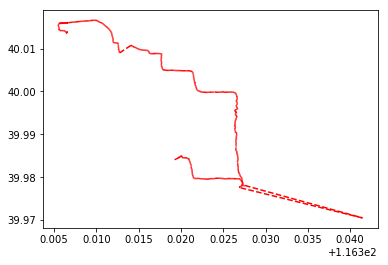

In [6]:
# plot the path
import matplotlib.pyplot as plt

for i in range(len(gpsdata3)):
    lat, lng = tuple(gpsdata3.iloc[i, :2])
    #plt.scatter(lng, lat)
    try:
        n_lat, n_lng = tuple(gpsdata3.iloc[i+1, :2])
        plt.plot((lng, n_lng),(lat, n_lat), "r--")
    except IndexError:
        pass
plt.show()

In [7]:
gpsdata2 = np.array([[53.3854313241815,-1.4932127483203013, 1384209632918], 
                    [53.38609362252086,-1.4951305729482556, 1384209650218]])

distance = sum([calc_distance(gpsdata2[i][0], 
                              gpsdata2[i][1], 
                              gpsdata2[i+1][0], 
                              gpsdata2[i+1][1], "km") 
                for i in range(len(gpsdata2)-1)])
print("Distance traveled on GPS is {} km".format(distance))

Distance traveled on GPS is 0.14696399289179068 km


# Below are the codes for the using Cython to boost speed

In [8]:
%%cython
# or use %%cython -a for more details

cimport cython

cdef extern from "math.h":
    double sin(double)
    double cos(double)
    double acos(double)
    double atan2(double, double)

cdef double pi = 3.141592654

@cython.cdivision(True)
cdef double radians(double deg):
    return deg/180.*(pi)

@cython.cdivision(True)
cdef double degrees(double rad):
    return rad * (180.0 / pi)

# from libc.math cimport acos, degrees, sin, cos, radians

cdef double calc_distance_km_c(double lat1, double lon1, 
                    double lat2, double lon2):
    cdef double theta, dist_angle, mile, km
        
    theta = lon1 -lon2
    dist_angle = sin(radians(lat1))* sin(radians(lat2)) \
            + cos(radians(lat1))* cos(radians(lat2)) \
            * cos(radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = acos(dist_angle)
    dist_angle = degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    km = mile * 1.609344
    return km

print(calc_distance_km_c(40.920320, -74.293288, 40.730975, -74.001509))

32.34059622449445


In [9]:
%%cython

cimport numpy as np
cimport cython
from libc.time cimport difftime
import calendar, time


cdef extern from "math.h":
    double sin(double)
    double cos(double)
    double acos(double)
    double atan2(double, double)
    double log(double)

cdef double pi = 3.141592654

@cython.cdivision(True)
cdef double radians(double deg):
    return deg/180.*(pi)

@cython.cdivision(True)
cdef double degrees(double rad):
    return rad * (180.0 / pi)

# from libc.math cimport acos, degrees, sin, cos, radians

cdef double calc_distance_km_c(double lat1, double lon1, 
                    double lat2, double lon2):
    cdef double theta, dist_angle, mile, km
        
    theta = lon1 -lon2
    dist_angle = sin(radians(lat1))* sin(radians(lat2)) \
            + cos(radians(lat1))* cos(radians(lat2)) \
            * cos(radians(theta))
    dist_angle = max(-1, min(dist_angle, 1))
    dist_angle = acos(dist_angle)
    dist_angle = degrees(dist_angle)
    mile = dist_angle * 60.0 * 1.1515
    km = mile * 1.609344
    return km

#cdef np.ndarray h = np.zeros([xmax, ymax], dtype=DTYPE)

def speed_cal_c(np.ndarray[np.float_t, ndim=2] gpsdata):
    """
    :param gpsdata: numpy 2 dimensional gps data, lat, long and UTC timestamp
    :return Speed in the gps data, km/hour
    """
    cdef int len_ = len(gpsdata)-1
    cdef double distance = 0.
    cdef double scale2sec, x_, x, run_time_in_sec, speed
    for i in range(len_):
        distance += calc_distance_km_c(gpsdata[i][0], gpsdata[i][1], gpsdata[i+1][0], gpsdata[i+1][1])
    # x_ = calendar.timegm(time.gmtime())
    x_ = 1187142632
    scale_ = gpsdata[0, 2] / x_
    scale_ = min([1.0, 10.0, 100.0, 1000.0], key=lambda x:abs(log(x)-log(scale_)))
    run_time_in_sec = max(gpsdata[:, 2])/scale_ - min(gpsdata[:, 2])/scale_
    speed = (distance / (run_time_in_sec / 3600.0))
    print("The distance traveled is {} km".format(distance))
    print("The time traveled is {} seconds".format(run_time_in_sec))
    print("The returned speed is in unit km/h")
    return speed


In [10]:
speed_cal_c(gpsdata2)

The distance traveled is 0.14696396221255864 km
The time traveled is 17.299999952316284 seconds
The returned speed is in unit km/h


30.582096267253124